In [1]:
#imports

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import csv

In [3]:
#read in file

#filename = '/Users/grudnick/Dropbox/Virgo_filaments/Zooniverse/final_2-classifications_COMPLETE.csv'
filename = '/Users/terrymechem/Desktop/SGA data exports/final_2-classifications_COMPLETE.csv'
db = pd.read_csv(filename)

In [4]:
pd.to_datetime(db['created_at'])

0       2025-04-11 17:05:03+00:00
1       2025-04-11 17:06:25+00:00
2       2025-04-11 18:06:20+00:00
3       2025-04-11 18:07:36+00:00
4       2025-04-11 18:09:45+00:00
                   ...           
35326   2025-06-12 15:26:51+00:00
35327   2025-06-12 15:26:58+00:00
35328   2025-06-12 15:27:01+00:00
35329   2025-06-12 15:27:04+00:00
35330   2025-06-12 15:27:06+00:00
Name: created_at, Length: 35331, dtype: datetime64[ns, UTC]

In [7]:
# Input timestamp
#timestamp_str = "2025-04-11 18:36:02 UTC"

# Convert to pandas datetime (with UTC timezone)
def dec_year(dt):
    

    # Get the year, day of year, and total days in the year
    year = dt.year
    day_of_year = dt.day_of_year
    total_days_in_year = 366 if (dt.year % 4 == 0 and (dt.year % 100 != 0 or dt.year % 400 == 0)) else 365

    # Calculate the decimal date
    decimal_date = year + (day_of_year - 1) / total_days_in_year

    #print(f"Decimal date: {decimal_date:.6f}")
    return decimal_date

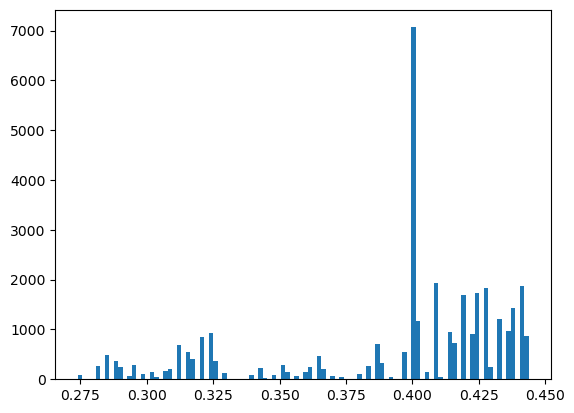

In [9]:
years = np.array([dec_year(dt) for dt in pd.to_datetime(db['created_at'])])

_ = plt.hist(years - 2025, bins=100)

In [74]:
#6/20/25 -- switching to use link instead of galaxy name, since there are a handful of galaxies
#with the same SGA name that are in either the north or south, and the links differentiate while the names don't
#-- this fixes the issue of the 500 or so missing subjects, now there are just 2 missing due to not having
#any usable classifications.

#annotations_json = [json.loads(q) for q in db.annotations]
#print(annotations_json)
#print(db['annotations'])
#print(db['annotations'][1])

gals_data = {}    #all galaxies, classification data ordered by galaxy. Dictionary of list of lists - gal name: [[T0 data], [T1 data], etc]

no_issues = []    #for subjs with no issues, at least one confident classification, no comments.
        #List - gal name
NI_unconf = []    #for subjs with no issues but all classifications were marked as unconfident
        #or at least one had a comment. List of lists - gal name, [comment1,comment2]

#initialize counter for number of classifications with 
count_ellipse = 0    #>1 missing ellipse
count_oversize = 0   #>1 oversized ellipse 
count_ncent = 0      #>1 uncentered ellipse 

none = 0 ####
gals_none = {} ####


#loop through every classification
for index, row in db.iterrows():
    #print(row)

    #galaxy subject for each classification
    #_, gal = row['subject_data'].split(f'"Galaxy":"')
    #gal = gal.rstrip(f'"}}')
    _, gal = row['subject_data'].split(f'"Link":"')
    gal, _ = gal.split(f'","Galaxy"')
    
    #print(gal)

    #extract all annotations (user input) for this classification
    anno = row['annotations']

    #This makes a list of dictionaries, with one list element per task.
    anno_json = json.loads(anno)
    #print(anno_json)

    #initialize values for tasks.  These numbers are sequential in workflow execution order.  
    #This is not sequential in task number because once you define a task you can't redefine it's name
    #when you change the order
    T7_val = ''
    T0_val = ''
    T2_val = ''
    T3_val = ''
    T5_val = ''
    T6_val = ''
    T4_val = ''

    #goes through each task in the list for that classification and fills values for each task.
    for i in range(len(anno_json)):    
        task = anno_json[i]
        
        #these are arranged by the final workflow order
        if task['task'] == 'T7':    #No issues
            T7_val = task['value']
                
        if task['task'] == 'T0':    #Good/Bad
            T0_val = task['value']

        if task['task'] == 'T2':    #Missing Ellipse
            T2_val = task['value']

            #coordinates of the missing ellipse
            if str(T2_val) != '[]':
                if len(T2_val) > 0:    #if number of pts in classification > 0
                    #print(gal,len(T2_val), T2_val)
                    if len(T2_val) > 1:
                        count_ellipse += 1

                    #initialize array that will hold coordinates
                    coords = np.array([])
                    for iell in range(len(T2_val)):
                        coords = np.append(coords, {'x': T2_val[iell]['x'], 'y': T2_val[iell]['y']})
                T2_val = coords
            else:
                T2_val = 'no points'

        #coordinates of oversized ellipses
        #NOTE for terry: Check if this is right
        if task['task'] == 'T3':    #Oversized Ellipse
            T3_val = task['value']

            if str(T3_val) != '[]':
                if len(T3_val) > 0:
                    if len(T3_val) >1:
                        count_oversize += 1

                    #initialize array that will hold coordinates
                    coords = np.array([])
                    for iell in range(len(T3_val)):
                        coords = np.append(coords, {'x': T3_val[iell]['x'], 'y': T3_val[iell]['y']})
                T3_val = coords
            else:
                T3_val = 'no points'
                
        #coordinates of Not Centered Ellipse
        #NOTE for terry: Check if this is right
        if task['task'] == 'T5':    
            T5_val = task['value']

            if str(T5_val) != '[]':
                if len(T5_val) > 0:
                    if len(T5_val) > 1:
                        count_ncent += 1

                    #initialize array that will hold coordinates
                    coords = np.array([])
                    for iell in range(len(T5_val)):
                        coords = np.append(coords, {'x': T5_val[iell]['x'], 'y': T5_val[iell]['y']})
                T5_val = coords
            else:
                T5_val = 'no points'
                
        if task['task'] == 'T6':    #Confidence
            T6_val = task['value']

        if task['task'] == 'T4':    #Comments
            T4_val = task['value']

    #NOTE change all lists to arrays. 
    #NOTE don't use strings for elements of coordinates but keep as dictionaries
    #print(T7_val,T0_val,T2_val,T3_val,T5_val,T6_val,T4_val)
    task_list = np.array([])
    task_list = np.append(task_list, T7_val)
    task_list = np.append(task_list, T0_val)
    task_list = np.append(task_list, T2_val)
    task_list = np.append(task_list, T3_val)
    task_list = np.append(task_list, T5_val)
    task_list = np.append(task_list, T6_val)
    task_list = np.append(task_list, T4_val)
#    task_list = np.array([T7_val, T0_val, T2_val, T3_val, T5_val, T6_val, T4_val])
    #print(task_list)

    
    if T7_val == None:    #problem with 'no issues' task. Described below
        _ = 0
        none += 1
        if gal not in gals_none:
            gals_none[gal] = 1
        else:
            gals_none[gal] += 1

    #NOTE: change this to be element by element test and don't worry about too many nested if statements 
    #elif task_list == ['', 'Good', '[]', '[]', '[]', 'I am confident.', '']:  #manually adds T7 answer
    #    task_list[0] = 'Yes'
    else:
        counter = 0    #initialize counter variable for element-by-element test
        
        if task_list[1] == 'Good':
            counter += 1
        if task_list[2] == 'no points':
            counter += 1
        if task_list[3] == 'no points':
            counter += 1
        if task_list[4] == 'no points':
            counter += 1
        if task_list[5] == 'I am confident.':
            counter += 1
        if task_list[6] == '':
            counter += 1

        if counter == 6:
            task_list[0] = 'Yes'
    
        
        elif task_list[0] != 'Yes':
            task_list[0] = 'No'

    
    #NOTE: comment this better.
    if gal not in gals_data:
        if task_list[0] != None:    #removes the null classifications

            gals_data[gal] = [task_list]
        
            #elif type(gals_data[gal][i]) == str:
            #    for i in range(len(task_list)):
            #        gals_data[gal][i] = [gals_data[gal][i], task_list[i]]

            #elif type(gals_data[gal][i]) == list:
            #    for i in range(len(task_list)):
            #        gals_data[gal][i].append(task_list[i])
        
        #else:
        #    gals_data[gal] = ['Null']
       
    else:
       if task_list[0] != None:    #removes the null classifications

            gals_data[gal].append(task_list)
        
            #elif type(gals_data[gal][i]) == str:
            #    for i in range(len(task_list)):
            #        gals_data[gal][i] = [gals_data[gal][i], task_list[i]]

            #elif type(gals_data[gal][i]) == list:
            #    for i in range(len(task_list)):
            #        gals_data[gal][i].append(task_list[i])
        
       #else:
       #    gals_data[gal].append('Null')
           #print(gal, "***************appended None")
#            gals_data[gal].append(task_list)



print('number of classifications with multiple missing ellipses = ', count_ellipse)
print('number of classifications with multiple oversized ellipses = ', count_oversize)
print('number of classifications with multiple uncentered ellipses = ', count_ncent)
print(f'number of classifications with "none" error = {none}')
#There's an issue after the 'no issues' task was added where, if the question was skipped (value = null), any data from after
#that point isn't on the export data. Not sure if there's a way to fix this, as is, there's 576 classifications with this issue. For now
#I've made it so those classifications are excluded.
#I'm also not sure why the length of gals_data isn't equal to the number of subjects, since even those null classifications are
#still included.

print(len(gals_data))
count_1class = 0
for gal in gals_data:
    if len(gals_data[gal]) < 2:
#        print(gal,len(gals_data[gal]),gals_data[gal])
        count_1class = count_1class + 1

#for gal in gals_data:
#    print(gal, gals_data[gal])

print('number with one classification = ', count_1class)
#print(gals_none)
print('galaxies with no real classifications:')
for gal in gals_none:
    if gals_none[gal] > 1:
        print(gal, gals_none[gal])

#with open('gals_none_manifest.csv', 'w', newline='') as file:
#    writer = csv.writer(file)
#    writer.writerows([gals_none, )

#print("CSV file 'gals_none_manifest.csv' created successfully.")


number of classifications with multiple missing ellipses =  213
number of classifications with multiple oversized ellipses =  143
number of classifications with multiple uncentered ellipses =  20
number of classifications with "none" error = 576
16803
number with one classification =  547
galaxies with no real classifications:
https://portal.nersc.gov/project/cosmo/temp/SGA2025/zooniverse/project1/dr9-north/annotate/131/SGA2025_J131.0312+66.9622.png 2
https://portal.nersc.gov/project/cosmo/temp/SGA2025/zooniverse/project1/dr9-north/annotate/125/SGA2025_J125.0072+62.8305.png 2


# Things for Terry to do

* Make a new manifest with only the 519 galaxies that need a second classification
* Classify those galaxies (ask Maddy to help)
* Make a row-matched list with the length of the original manifest but with flags for each of the tasks and with a string field for the comment.
* Talk to John to see how he wants the lists of alternate positions and ellipse info

In [78]:
manifestdf = pd.read_csv('/Users/terrymechem/Downloads/inventory_manifest_Fv1.csv')
manifest = manifestdf.values.tolist()
#print(manifest)

fin_manifest = [['Link','Galaxy']]
print(len(gals_none))
#print(gals_none)

for gal in gals_none:
    for row in manifest:
        #print(row)
        #print(row[1])
        if row[0] == gal:
            #links.append(row[0])
            #print('a')
            fin_manifest.append([gal,row[1]])
            #print(f'{gal}\n{row[1]}')


print(len(fin_manifest))
with open('gals_none_manifest.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(fin_manifest)
#print(fin_manifest)
print("CSV file 'gals_none_manifest.csv' created successfully.")


574
575
CSV file 'gals_none_manifest.csv' created successfully.
